In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = False
do_training = True
plot_train_curve = False
save_synthetic_samples = np.hstack([np.array([1, 5, 10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'

Give me the class type.
chair


In [5]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'mlp_pc_gen_default_leak_20'

leak = 0.2
adaptive_training = None
beta = 0.5

discriminator = mlp_discriminator
generator = point_cloud_generator

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
init_lr = 0.0001

disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
gen_kwargs = {'b_norm': False}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [6]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [7]:
training_data = in_data['train']
n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [8]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3655098801073822, 0.7039441756580187) 27.2401378155


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


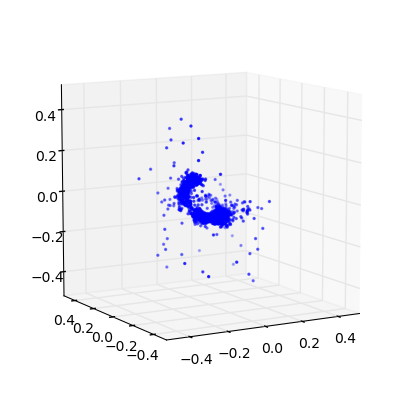

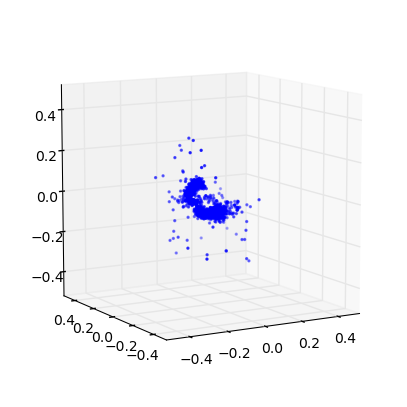

2 (1.3511095700056657, 0.73067726259646204) 26.9981818199
3 (1.2615606225055196, 0.82765874188879263) 27.1567759514
4 (1.0827460195707239, 1.0573046964147816) 27.3798708916
5 (1.3676071172175199, 0.83560515227525134) 27.490281105


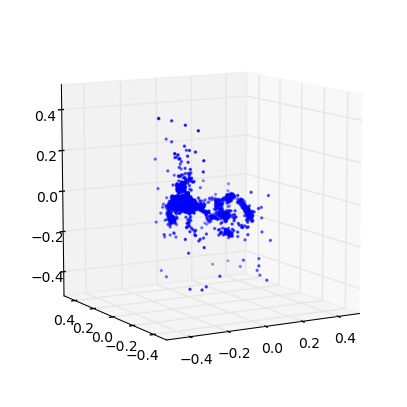

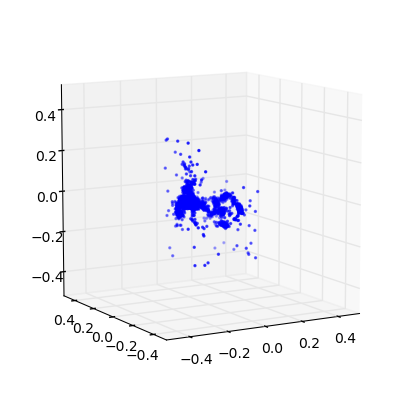

6 (1.3264919198077658, 0.74728119995283049) 27.4376530647
7 (1.3160610976426497, 0.77971109929292093) 27.5998311043
8 (1.3123974748279736, 0.79499859395234485) 27.4353098869
9 (1.3167422947676286, 0.77966785016267193) 27.6049559116
10 (1.3157053595003874, 0.78277481846187424) 27.3841741085


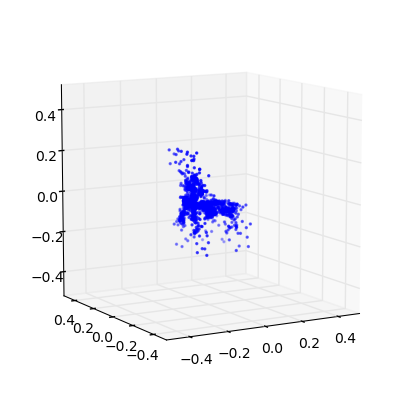

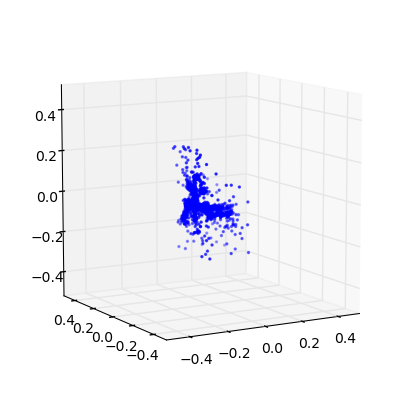

11 (1.3067456618599269, 0.79157080883565156) 27.4819769859
12 (1.3020511782687643, 0.80000167592712068) 27.5722601414
13 (1.2996388342069543, 0.80105980505114016) 27.6600821018
14 (1.2926450750102167, 0.80285673867101259) 27.6852650642
15 (1.3126523432524309, 0.79321969281072202) 27.5373549461
16 (1.3163740894068843, 0.79114181010619455) 27.6272308826
17 (1.3214364621950232, 0.78874367656915079) 27.6915509701
18 (1.3270139632017717, 0.77814426370289014) 27.5119869709
19 (1.3358420392741328, 0.77858024058134656) 27.687417984
20 (1.3241818687190181, 0.77063192077305009) 27.5150790215
21 (1.3272917001143745, 0.78049555602280984) 27.6664810181
22 (1.3182716214138528, 0.78359738406927693) 27.4263501167
23 (1.3164347161417422, 0.78494073126627051) 27.7885959148
24 (1.3163221110468326, 0.796788647900457) 27.4517030716
25 (1.3127915859222412, 0.78493488638297371) 27.7001609802
26 (1.3184675952662592, 0.78504840653875596) 27.6258029938
27 (1.3240913639897887, 0.79130179933879685) 27.7225301266


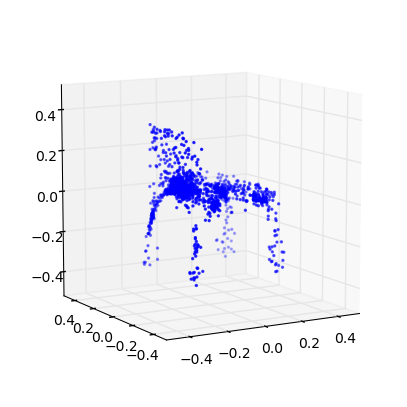

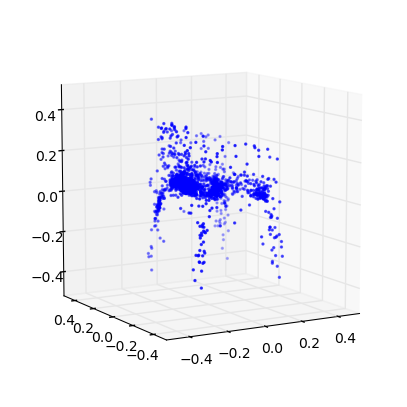

51 (1.33937800137893, 0.77191847303639283) 27.5788900852
52 (1.3345672700716102, 0.77040413669917895) 27.4841339588
53 (1.3392002509987873, 0.77121147928030598) 27.5251939297
54 (1.3379679161569347, 0.77009076709332669) 27.6716930866
55 (1.3425471761952277, 0.77268838312314903) 27.5501260757
56 (1.3492696285247803, 0.77775017930113755) 27.4607107639
57 (1.3385002364283023, 0.77216867312141091) 27.4468472004
58 (1.3428825875987178, 0.76410366659579065) 27.5148820877
59 (1.3457173876140429, 0.77093027415482895) 27.4521951675
60 (1.3393529601719067, 0.76602300250011945) 27.5409388542
61 (1.3436806658039921, 0.76643425070721172) 27.5130848885
62 (1.3511276680490245, 0.76622268065162324) 27.382833004
63 (1.347833892573481, 0.76766643213189167) 27.5325450897
64 (1.34377847754437, 0.76842823235884961) 27.4302470684
65 (1.3386115872341653, 0.76328342945679373) 27.3962609768
66 (1.3476556736490002, 0.76928411722183232) 27.6475069523
67 (1.3417484801748525, 0.76786870489949766) 27.4724910259
68 

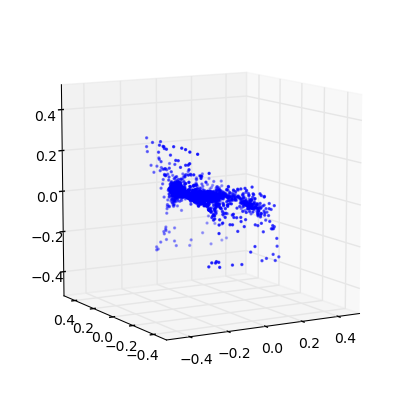

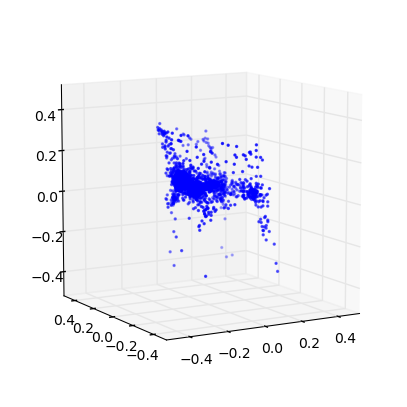

101 (1.3440994231597236, 0.76251885165338928) 27.3204660416
102 (1.3499499300251836, 0.76534375496532603) 27.1848168373
103 (1.3449397439542023, 0.76551572602728135) 27.2926299572
104 (1.3504643253658128, 0.76170772365901784) 27.3794071674
105 (1.3422445960666822, 0.76339095830917358) 27.4919421673
106 (1.3464952676192574, 0.76702086484950527) 27.3731479645
107 (1.3440332848092784, 0.76122750924981164) 27.5747711658
108 (1.3498514393101568, 0.76404513250226558) 27.2789402008
109 (1.348059170142464, 0.76273886794629309) 27.4744558334
110 (1.3487433817075647, 0.76314714421396668) 27.4605288506
111 (1.3463809687158337, 0.76524986080501389) 27.3314180374
112 (1.3495906995690388, 0.76399389920027361) 27.2855679989
113 (1.3465182760487433, 0.76426042732985122) 27.3683350086
114 (1.3492980086285136, 0.76452435514201289) 27.3579258919
115 (1.3507018960040549, 0.7649608596511509) 27.3495941162
116 (1.3512436794198077, 0.7617181891980378) 27.3505620956
117 (1.3501825457033905, 0.7598304914391559

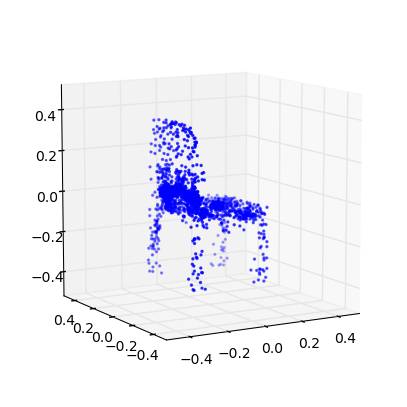

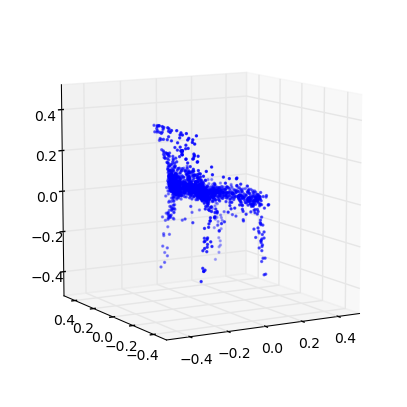

151 (1.3522158135538516, 0.76252109900764797) 27.3313920498
152 (1.3505980408709981, 0.7587369265763656) 27.529102087
153 (1.3509680665057637, 0.76181454036546792) 27.6685910225
154 (1.351035677868387, 0.75921522327091384) 27.572676897
155 (1.357517839514691, 0.75833223539849981) 27.4875621796
156 (1.3541881333226744, 0.76322644223337588) 27.1396801472
157 (1.3525459102962327, 0.76417642883632497) 27.2126860619
158 (1.3536287359569383, 0.76302870304688164) 27.1157348156
159 (1.3552046651425569, 0.76400358365929644) 27.2238848209
160 (1.3493544474891994, 0.76648453681365303) 27.1240141392
161 (1.352497752853062, 0.76316466020501184) 27.3778829575
162 (1.3497544122778851, 0.76534952080768093) 27.2931308746
163 (1.3502686635307644, 0.76941834066225134) 27.3753380775
164 (1.3497765551442686, 0.76633919477462764) 27.144671917
165 (1.3454953349154928, 0.76577189331469331) 27.1740069389
166 (1.3492715773375139, 0.77226535444674282) 27.1449739933
167 (1.3476839832637622, 0.77416983065397849) 2

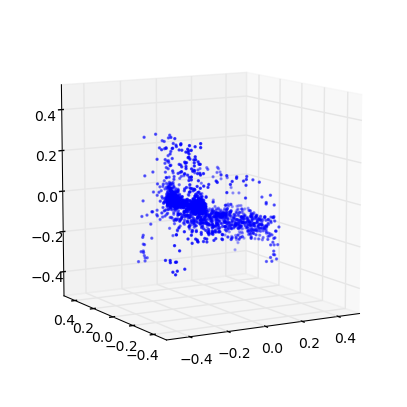

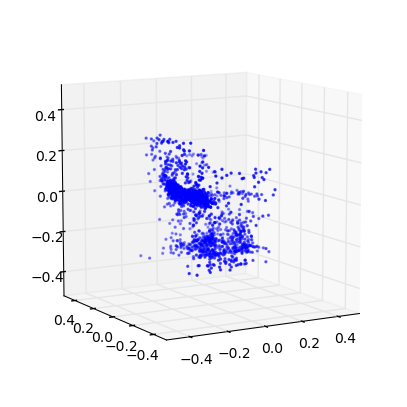

201 (1.3502154661261516, 0.76589152087335999) 27.3015379906
202 (1.3542242599570233, 0.76974785431571624) 27.2224779129
203 (1.3494664472082387, 0.77215359677439155) 27.3661181927
204 (1.3466269627861354, 0.77375543428503946) 27.6509928703
205 (1.3463359967521999, 0.76706126461858337) 27.3454220295
206 (1.346196903353152, 0.7716044788775237) 27.3681340218
207 (1.3451793940170951, 0.77275222850882486) 27.7151768208
208 (1.3433375638464222, 0.76916548376498017) 27.4511170387
209 (1.3476766150930652, 0.77617596128712529) 27.514056921
210 (1.3428063620691715, 0.77492170541182803) 27.3360130787
211 (1.3451580793961235, 0.77514551618824834) 27.5769190788
212 (1.345295034284177, 0.77495618022006496) 27.6767699718
213 (1.3453071386917779, 0.77367605852044152) 27.4309921265
214 (1.347230887413025, 0.77631198530611789) 27.3625171185
215 (1.3469827071480129, 0.77702608834142273) 27.6414370537
216 (1.3441611258879951, 0.77278837898503183) 27.432446003
217 (1.3458556973415872, 0.77594645800797835) 

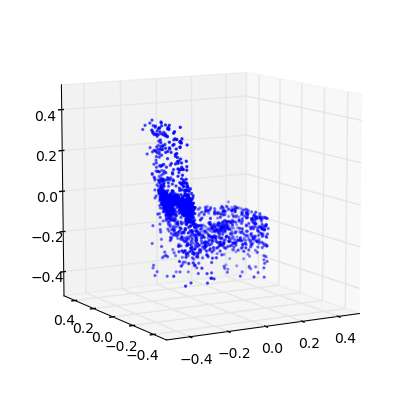

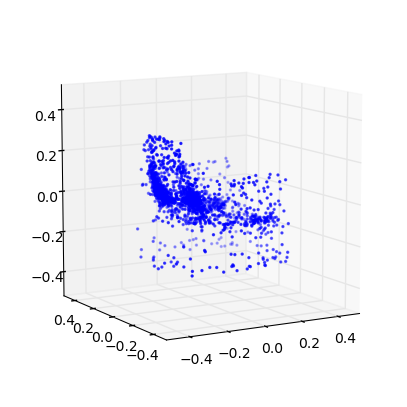

251 (1.330786240619162, 0.78515287223069563) 28.0217111111
252 (1.3360394716262818, 0.78537838044373887) 28.0572001934
253 (1.3309325695037841, 0.78871562895567526) 27.8829028606
254 (1.3275538164636362, 0.79157236037047018) 28.0737819672
255 (1.3323123330655304, 0.79062232815701028) 28.1301460266
256 (1.3357752768889717, 0.79409676893897674) 28.0559928417
257 (1.3330336964648704, 0.78706311764924419) 28.0671408176
258 (1.336003974209661, 0.79207294635150749) 28.2281320095
259 (1.3337064089982407, 0.78860512194426169) 28.170470953
260 (1.3319962853970735, 0.78242190402487055) 28.0641338825
261 (1.3345479177392048, 0.79034091700678288) 27.9418940544
262 (1.337214117464812, 0.78310705527015356) 28.2147657871
263 (1.3287011789238972, 0.78625021499136216) 28.2023460865
264 (1.3323673486709595, 0.78499017124590664) 28.1967320442
265 (1.3372618270956951, 0.78375525319057959) 27.9927239418
266 (1.3312146477077318, 0.78614179621572078) 28.215695858
267 (1.3318235469901043, 0.78419386718584139)

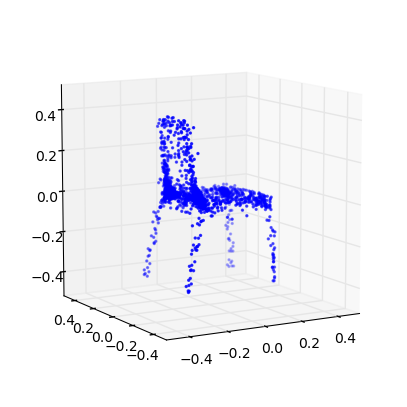

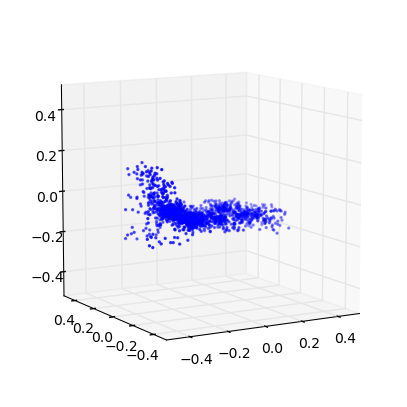

301 (1.3292023306307585, 0.79096080997715823) 28.0146591663
302 (1.3350722354391347, 0.78553506421006247) 27.7446269989
303 (1.3330616588177888, 0.78452030368473213) 28.0762310028
304 (1.3248207786808843, 0.79242683130761848) 27.9994449615
305 (1.3322282293568486, 0.79381814002990725) 28.0870840549
306 (1.3329974236695663, 0.79133455131364905) 27.9835100174
307 (1.3343226847441301, 0.78620388093202009) 28.1068189144
308 (1.3328943708668584, 0.78475326092346853) 27.9713840485
309 (1.3350996079652206, 0.7900607731031335) 27.9652061462
310 (1.3253338969272115, 0.78781671213067095) 27.7949390411
311 (1.3261135474495265, 0.78605249446371328) 28.1148900986
312 (1.3281109892803691, 0.79351182761399641) 28.2080798149
313 (1.3300512832144031, 0.78631500886834182) 27.7305281162
314 (1.3244405694629835, 0.79616226061530737) 28.1231930256
315 (1.3233499755030094, 0.79708574595658677) 28.3092110157
316 (1.3270014275675235, 0.79124089479446413) 28.1604781151
317 (1.3276016017665033, 0.79665027494015

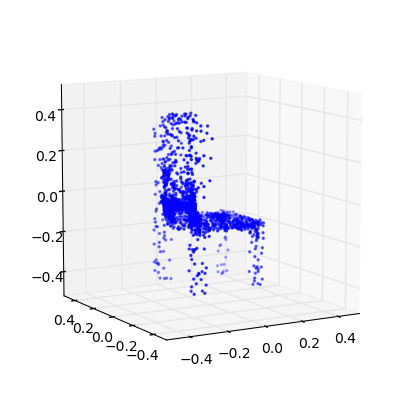

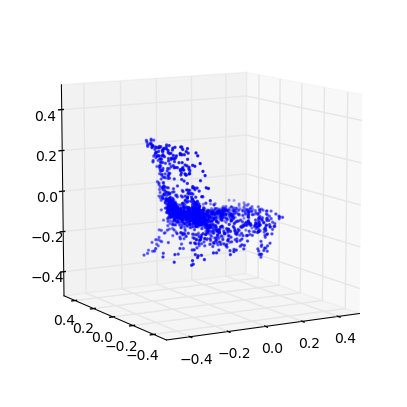

351 (1.3112954450690228, 0.80623553369356238) 28.0183160305
352 (1.3229717088782269, 0.80766523143519531) 28.0906801224
353 (1.3038326045741206, 0.81013893718304841) 28.1998841763
354 (1.3131189916444861, 0.80714024357173753) 28.4181859493
355 (1.3154555921969207, 0.81336394600246265) 28.0429871082
356 (1.3162992415220842, 0.81347708598427149) 28.2352888584
357 (1.3058798634487649, 0.81557070742482729) 27.9714269638
358 (1.3061040847197822, 0.81909333726634148) 27.8953301907
359 (1.3174831514773162, 0.81029501142709148) 27.9745719433
360 (1.3111737344575964, 0.81211960263874217) 27.8684260845
361 (1.3063293799110081, 0.81399126933968591) 28.2233800888
362 (1.3207640326541403, 0.81311333127643748) 28.0802788734
363 (1.3117867874062579, 0.81033420510914012) 28.0616919994
364 (1.3161925492079363, 0.80724739017693892) 27.8438699245
365 (1.3187176040981128, 0.80205914300421011) 28.2080109119
366 (1.3129111963769664, 0.81909456460372265) 28.1426820755
367 (1.3178791699202164, 0.8051032512084

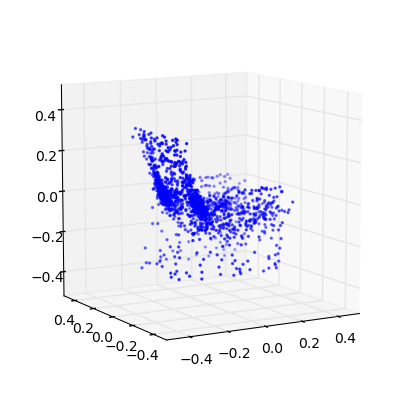

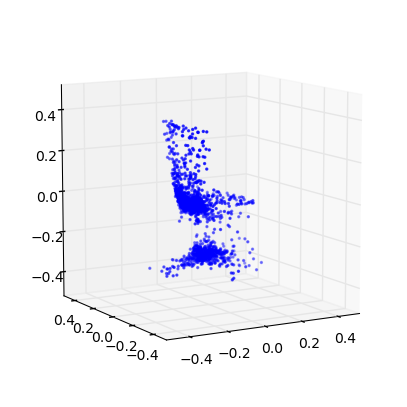

401 (1.3125870818677157, 0.81042844264403635) 27.7202849388
402 (1.3106098237244979, 0.81378100540326992) 27.5525081158
403 (1.2980579034141873, 0.82505194622537359) 27.5073370934
404 (1.3099826304808906, 0.8056070436602053) 27.6499071121
405 (1.3106512639833534, 0.81631753030030618) 27.7143199444
406 (1.3077519230220629, 0.81683740564014595) 27.51770401
407 (1.3054818391799927, 0.81942721346150271) 27.5225830078
408 (1.3105894897295081, 0.80771696774855906) 27.3032820225
409 (1.3146542932676233, 0.81028691141501719) 27.646517992
410 (1.2940332236497298, 0.81736655494441157) 27.7307851315
411 (1.3080573268558668, 0.81682622795519622) 27.6698448658
412 (1.3027404266854992, 0.81156950618909751) 27.8313159943
413 (1.3046645143757696, 0.8165034050526826) 27.6430499554
414 (1.3060889575792396, 0.81332522527031281) 28.1923770905
415 (1.3131193212840868, 0.79706118521483049) 27.6246209145
416 (1.3075069645176762, 0.81940469119859782) 27.995070219
417 (1.3062444407006968, 0.81287869733312856) 

In [ ]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
        train_stats.append((epoch,) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')